# <center>CMPBIO210, IB120, IB201
# <center>"Introduction to Quantitative Methods in Biology"
# <center>Lecture 5. ODE Models of infection epidemics
## <center>Denis Titov

**The goal of this jupyter notebook is to discuss how to formulate, solve and analyze ODE model of infection dynamics**

Optional additional resources:  
 https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology  
 https://julia.quantecon.org/continuous_time/seir_model.html  
 https://julia.quantecon.org/continuous_time/covid_sde.html  


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from scipy.integrate import solve_ivp

## SIR Model of COVID19

SIR stands for Susceptible, Infected, Removed.

Assumption of the model:
- $Susceptible$ people can be infected when the meet with $Infected$ people at a rate $\beta$
- $Infected$ people recover at a rate $\gamma$ and become $Removed$
- $Removed$ people cannot be infected as they are immune or deceased
- $Total Population$ is large and everyone is interacting with everyone with equal probability
  
Some general suggestion about how to write down differential equations model:  
- Number of equations should be equal to number of variable that depend on time in your model. E.g., we have three time-dependent variables $Susceptible$, $Infected$, $Removed$ that change over time.  
- In many models, you'll have some combination of variables that are conserved so it is  good practice to keep track of those conserved values (i.e., plot them as part of solution) to ensure that they stay conserved and if they are not conserved then you wrote down some equations wrong. E.g., Total Population is conserved here, total amount of phosphorylated and unphosphorylated protein is conserved in the absence of translation and protein degradation, total amount of some phosphate atoms inside the cell is conserved in the absence of phosphate uptake or secretions etc.  
- Related to conservation, when one variable is transformed into another then differential equations for these variable should have mirror consumbption/production terms. E.g., $Susceptible$ and $Infected$ or $Removed$ and $Infected$ terms in this model.  
  
The model is then:  
  
$\frac{dSusceptible}{dt}=-\beta \cdot \frac{Susceptible}{Total} \cdot Infected$  
  
$\frac{dInfected}{dt}=\beta \cdot \frac{Susceptible}{Total} \cdot Infected - \gamma \cdot Infected$  

$\frac{dRemoved}{dt}=\gamma \cdot Infected$  
  
$Total \space Population = Susceptible + Infected + Removed$


  Note that in order for the above model to be balance (i.e. no new individuals are produced out of nothing) you have to make sure that the rate of disappearance of one species (e.g. for $S$ rate of disapperance is $-\beta \cdot \frac{Susceptible}{Total} \cdot Infected$) appears as the rate of appearance of another species (e.g. for $I$ rate of appearance is $-\beta \cdot \frac{Susceptible}{Total} \cdot Infected$). Otherwise your model will be obviously wrong as you'll have $Total \space Population$ changing over time.

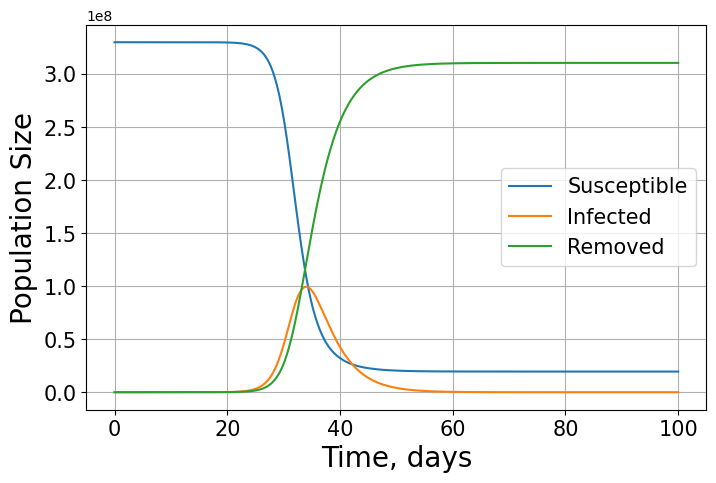

In [17]:
β = 0.9 #units of people/day
γ = 0.3 #units of 1/day


def SIR_Model(t, y):
    S, I, R = y
    N = S + I + R
    dSdt = -β * (S / N) * I
    dIdt = β * (S / N) * I - γ * I
    dRdt = γ * I
    return [dSdt, dIdt, dRdt]


initial_condition = [330e6, 1, 0]
tspan = [0, 100]
soln = solve_ivp(
    SIR_Model, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
)

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(soln.t, soln.y[0], label="Susceptible")
plt.plot(soln.t, soln.y[1], label="Infected")
plt.plot(soln.t, soln.y[2], label="Removed")
plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(fontsize=15);

It is always a good idea to do various sanity checks of your model.  
For example, for SIR model above we can check that $Total \space Population$ stays constant.  
Checking for conservation of sum  of dynamic variables in your model is a good way to find errors in your model.  

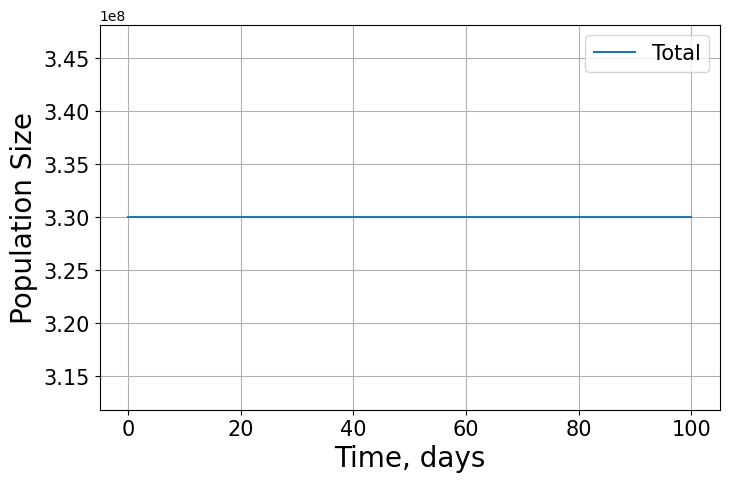

In [15]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(soln.t, (soln.y[0] + soln.y[1] + soln.y[2]), label="Total")
plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(fontsize=15);

## Fixed points of SIR model and $R_0$

One of the goals of epidemiological modeling is to figure out how to prevent/stop infection from infecting many people.  
  
Let's analyze SIR model to see how we can do this:  
  
$N = S + I + R$
  
$\frac{dS}{dt}=-\beta \cdot \frac{S}{N} \cdot I$  
  
$\frac{dI}{dt}=\beta \cdot \frac{S}{N} \cdot I - \gamma \cdot I$  

$\frac{dR}{dt}=\gamma \cdot I$  
  
  We want $\frac{dS}{dt}=0, \frac{dI}{dt}=0$, and $\frac{dR}{dt}=0$  
  
  Solutions for $\frac{dS}{dt}=0$ and $\frac{dR}{dt}=0$ are boring: $S=0$, $I=0$.    
  Let's use SymPy to solve for $\frac{dI}{dt}=0$.  


In [12]:
β, γ, S, I, N = sym.symbols("β,γ,S,I,N")
sym.nonlinsolve([β * (S / N) * I - γ * I], [S])

{(N*γ/β,)}

The result is that $\frac{dI}{dt}=0$ when $\frac{S}{N}=\frac{\gamma}{\beta}$.  
  
  This result is so fundamental that $\frac{\beta}{\gamma}$ is called a reproductive number or $R_0$

## SIR model with $R_0$ 
  
Let's rewrite our SIR model using only $R_0$ and $\gamma$ to study significance of $R_0$:
  
$N = S + I + R$  
  
  $R_0=\frac{\beta}{\gamma}$
 
$\frac{dS}{dt}=-\gamma \cdot R_0 \cdot \frac{S}{N} \cdot I$  
  
$\frac{dI}{dt}=\gamma \cdot R_0 \cdot \frac{S}{N} \cdot I - \gamma \cdot I$  

$\frac{dR}{dt}=\gamma \cdot I$  
  
  Let's solve this new model with solve_ivp().  
  Compare new model using $R_0=3$, $\gamma=0.3$ with original model $\beta=3$, $\gamma=0.3$ to confirm that the results are exactly identical.

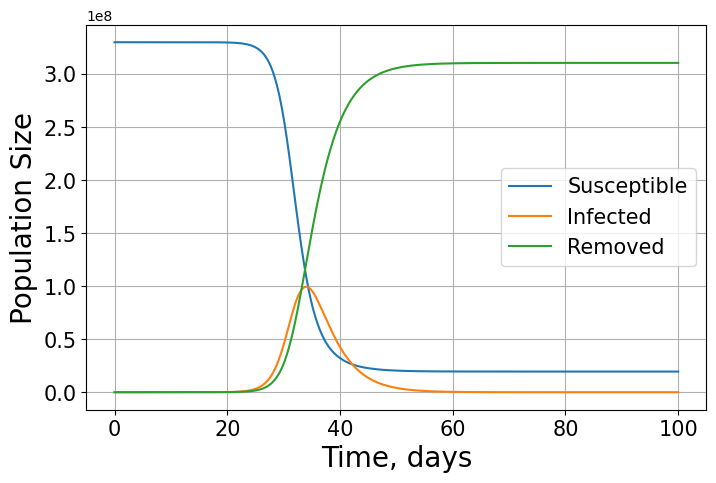

In [18]:
R0 = 3 #units of people
γ = 0.3 #units of 1/day


def SIR_Model(t, y):
    S, I, R = y
    N = S + I + R
    dSdt = -γ * R0 * (S / N) * I
    dIdt = γ * R0 * (S / N) * I - γ * I
    dRdt = γ * I
    return [dSdt, dIdt, dRdt]


initial_condition = [330e6, 1, 0]
tspan = [0, 100]
soln = solve_ivp(
    SIR_Model, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
)

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(soln.t, soln.y[0], label="Susceptible")
plt.plot(soln.t, soln.y[1], label="Infected")
plt.plot(soln.t, soln.y[2], label="Removed")
plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(fontsize=15);

Let's plot the results of SIR model with various values for $R_0$ and fixed $\gamma$

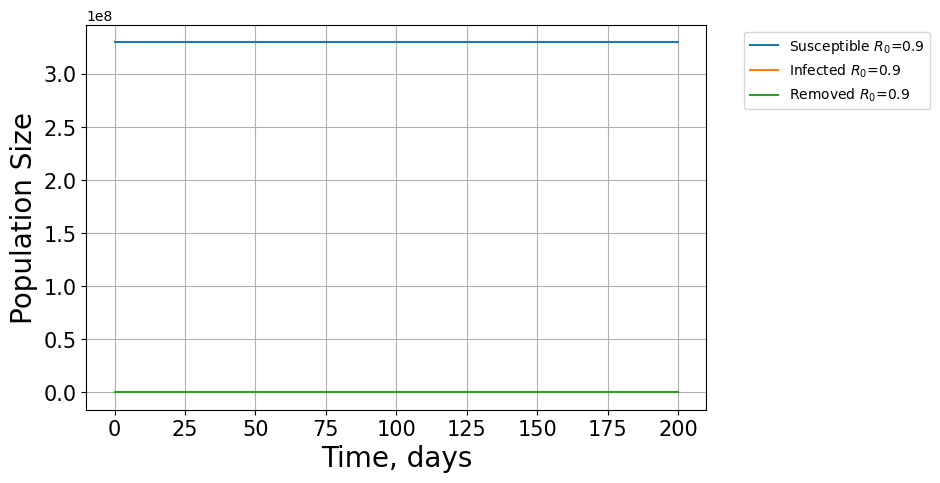

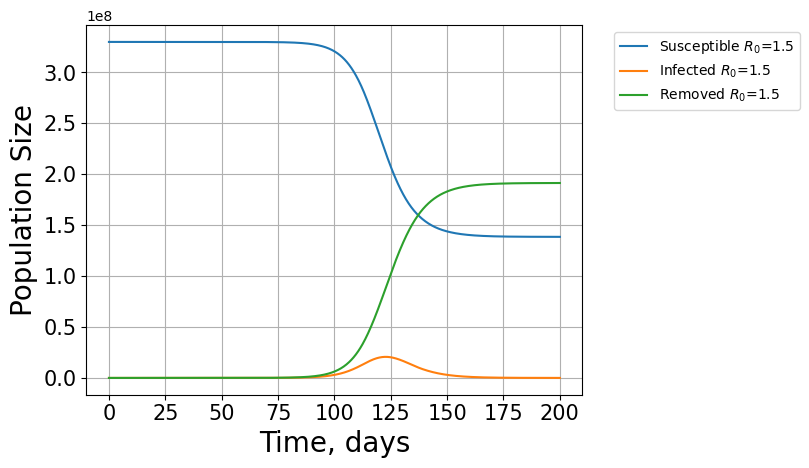

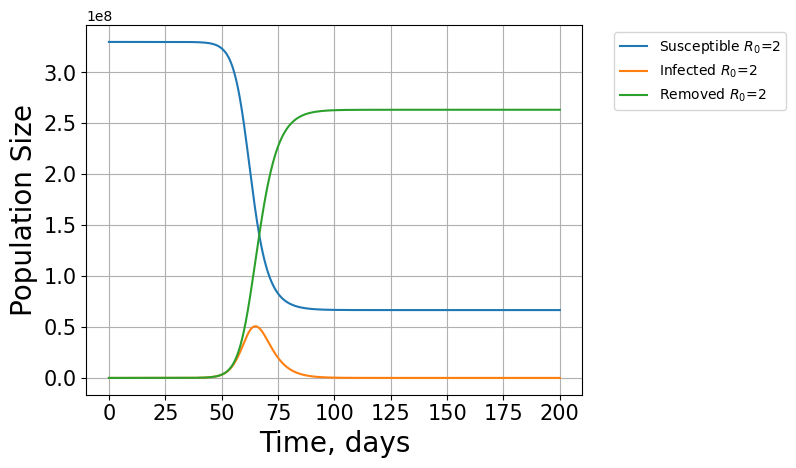

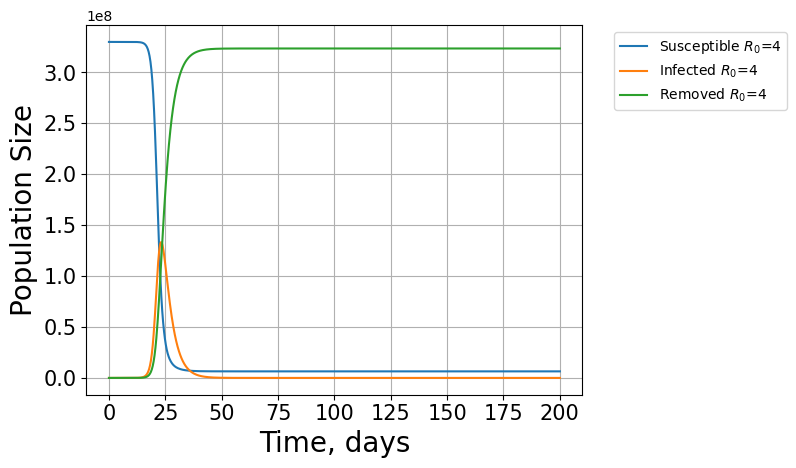

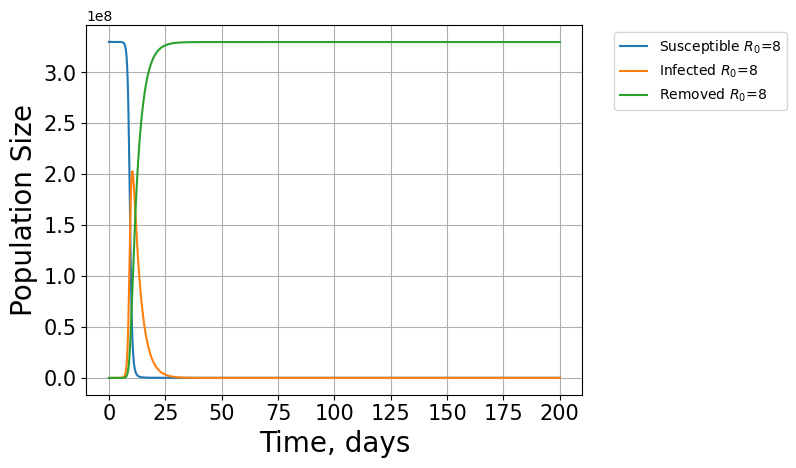

In [30]:
plt.figure(figsize=(8, 5), dpi=100)

for k in [0.9, 1.5, 2, 4, 8]:
    R0 = k
    γ = 0.3

    def SIR_Model(t, y):
        S, I, R = y
        N = S + I + R
        dSdt = -γ * R0 * (S / N) * I
        dIdt = γ * R0 * (S / N) * I - γ * I
        dRdt = γ * I
        return [dSdt, dIdt, dRdt]

    initial_condition = [330e6, 1, 0]
    tspan = [0, 200]
    soln = solve_ivp(
        SIR_Model, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
    )

    # Feel free to comment out 2 of the plots below using "#" to show less plots
    plt.plot(soln.t, soln.y[0], label=f"Susceptible $R_0$={R0}")
    plt.plot(soln.t, soln.y[1], label=f"Infected $R_0$={R0}")
    plt.plot(soln.t, soln.y[2], label=f"Removed $R_0$={R0}")

    plt.xlabel("Time, days", fontsize=20)
    plt.ylabel("Population Size", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #try changing ylim upper bound to see what happens at R0=1 or 0.99 or 0.5
    # plt.ylim(0,100)
    plt.grid()
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.show();

You can see from above results that the peak number of infected people and the fraction of the population that will get infected depends entirely on $R_0$.

Let's plot the results of SIR model with various values for $\gamma$ and fixed $R_0$

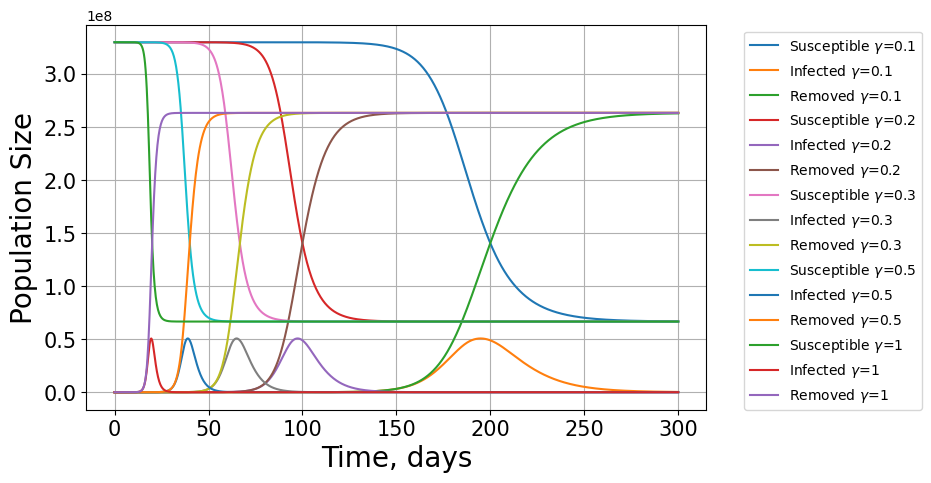

In [31]:
plt.figure(figsize=(8, 5), dpi=100)

for k in [0.1, 0.2, 0.3, 0.5, 1]:
    R0 = 2
    γ = k

    def SIR_Model(t, y):
        S, I, R = y
        N = S + I + R
        dSdt = -γ * R0 * (S / N) * I
        dIdt = γ * R0 * (S / N) * I - γ * I
        dRdt = γ * I
        return [dSdt, dIdt, dRdt]

    initial_condition = [330e6, 1, 0]
    tspan = [0, 300]
    soln = solve_ivp(
        SIR_Model, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
    )
    # Feel free to comment out 2 of the plots below using "#" to show less plots
    plt.plot(soln.t, soln.y[0], label=f"Susceptible $γ$={γ}")
    plt.plot(soln.t, soln.y[1], label=f"Infected $γ$={γ}")
    plt.plot(soln.t, soln.y[2], label=f"Removed $γ$={γ}")

plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left");

You can see from above results that the peak number of infected people and the fraction of the population that will get infected does not depends on $\gamma$ at all but the time when the peak is reached does depend on $\gamma$. In other words, $\gamma$ can be thought of as modifier of time and it can be removed from equations if we replace $t$ with $t \cdot \gamma$ leaving the SIR model with only one parameter $R_0$.  

## SIRD Model 
  
We can extend SIR model to include mortality:
  
$N = S + I + R + D$  
  
  $R_0=\frac{\beta}{\gamma}$
 
$\frac{dS}{dt}=-(\gamma + \mu) \cdot R_0 \cdot \frac{S}{N} \cdot I$  
  
$\frac{dI}{dt}=(\gamma + \mu) \cdot R_0 \cdot \frac{S}{N} \cdot I - (\gamma + \mu) \cdot I$  

$\frac{dR}{dt}=\gamma \cdot I$  
  
$\frac{dD}{dt}=\mu \cdot I$  

  
  Let's solve this new model with solve_ivp().  

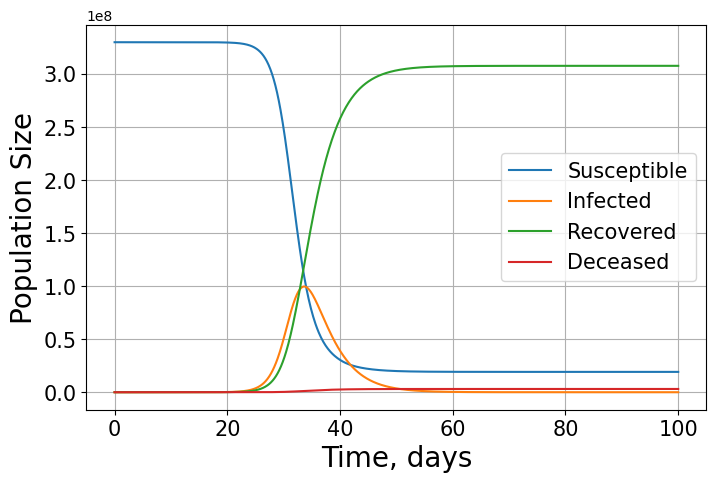

In [32]:
R0 = 3
γ = 0.3
μ = 0.003


def SIRD_Model(t, y):
    S, I, R, D = y
    N = S + I + R
    dSdt = -(γ + μ) * R0 * (S / N) * I
    dIdt = (γ + μ) * R0 * (S / N) * I - (γ + μ) * I
    dRdt = γ * I
    dDdt = μ * I

    return [dSdt, dIdt, dRdt, dDdt]


initial_condition = [330e6, 1, 0, 0]
tspan = [0, 100]
soln = solve_ivp(
    SIRD_Model, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
)

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(soln.t, soln.y[0], label="Susceptible")
plt.plot(soln.t, soln.y[1], label="Infected")
plt.plot(soln.t, soln.y[2], label="Recovered")
plt.plot(soln.t, soln.y[3], label="Deceased")

plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#try changing ylim upper bound to see what happened with D
#plt.ylim(0,5e6)
plt.grid()
plt.legend(fontsize=15);

## SIRD model with lockdowns
Lets explore how lockdowns would affect our model.  
We will assume that lockdown lowers $R_0$ from 2 to 0.8 for the duration of lockdown and returns to 2 after lockdown is over.

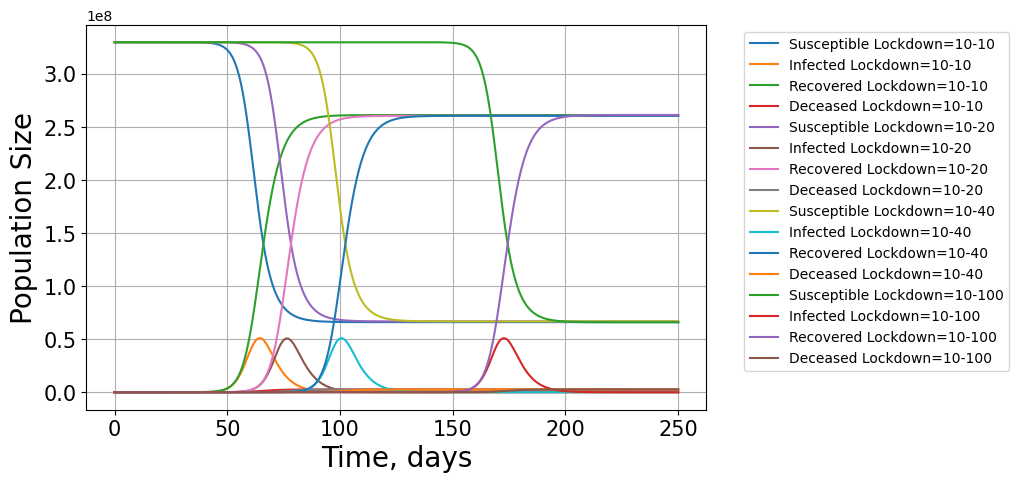

In [33]:
R0 = 2
γ = 0.3
μ = 0.003
plt.figure(figsize=(8, 5), dpi=100)

for k in [0, 10, 30, 90]:

    def SIRD_Model_w_lockdown(t, y):
        if 10 < t < 10 + k:
            R0 = 0.8
        else:
            R0 = 2

        S, I, R, D = y
        N = S + I + R
        dSdt = -(γ + μ) * R0 * (S / N) * I
        dIdt = (γ + μ) * R0 * (S / N) * I - (γ + μ) * I
        dRdt = γ * I
        dDdt = μ * I

        return [dSdt, dIdt, dRdt, dDdt]

    initial_condition = [330e6, 1, 0, 0]
    tspan = [0, 250]
    soln = solve_ivp(
        SIRD_Model_w_lockdown, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
    )

    plt.plot(soln.t, soln.y[0], label=f"Susceptible Lockdown=10-{10+k}")
    plt.plot(soln.t, soln.y[1], label=f"Infected Lockdown=10-{10+k}")
    plt.plot(soln.t, soln.y[2], label=f"Recovered Lockdown=10-{10+k}")
    plt.plot(soln.t, soln.y[3], label=f"Deceased Lockdown=10-{10+k}")

plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#try changing ylim upper bound to see what happens at with I during lockdown
# plt.ylim(0,100)
plt.grid()
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left");

Lets the effect of $R_0$ on lockdown.

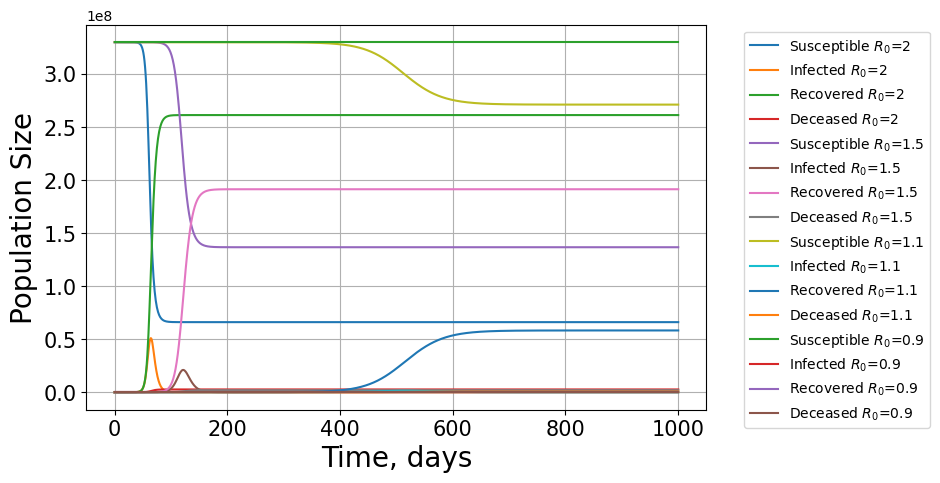

In [34]:
R0 = 2
γ = 0.3
μ = 0.003
plt.figure(figsize=(8, 5), dpi=100)

for k in [2, 1.5, 1.1, 0.9]:

    def SIRD_Model_w_lockdown(t, y):
        R0 = k
        S, I, R, D = y
        N = S + I + R
        dSdt = -(γ + μ) * R0 * (S / N) * I
        dIdt = (γ + μ) * R0 * (S / N) * I - (γ + μ) * I
        dRdt = γ * I
        dDdt = μ * I

        return [dSdt, dIdt, dRdt, dDdt]

    initial_condition = [330e6, 1, 0, 0]
    tspan = [0, 1000]
    soln = solve_ivp(
        SIRD_Model_w_lockdown, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
    )

    plt.plot(soln.t, soln.y[0], label=f"Susceptible $R_0$={k}")
    plt.plot(soln.t, soln.y[1], label=f"Infected $R_0$={k}")
    plt.plot(soln.t, soln.y[2], label=f"Recovered $R_0$={k}")
    plt.plot(soln.t, soln.y[3], label=f"Deceased $R_0$={k}")

plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#try changing ylim upper bound to see what happens at with I during lockdown
# plt.ylim(0,100)
plt.grid()
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left");

You can see that lockdwon would slow down the onset of a peak of infections but will not lower or prevent it.  Therefore, lasting changes to $R_0$ or $\mu$ should be implemented during lockdown to change the course of the pandemic based on this simple model.

## SIRD model with vaccination
Lets explore how vaccination would affect our model.  
We will assume that vaccination converts $Susceptible$ people to $Recovered$.  
We will introduce parameter k which $FractionVaccinated$.

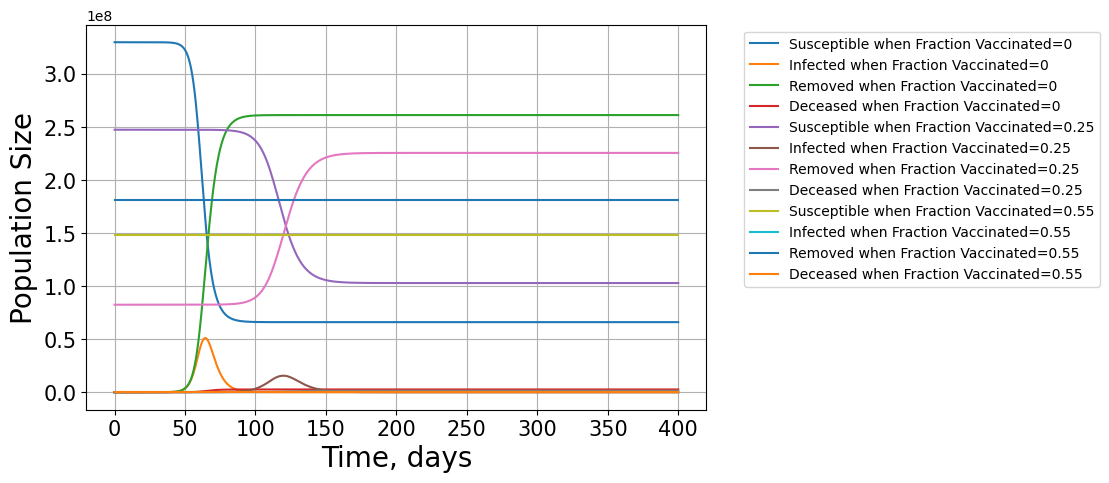

In [35]:
plt.figure(figsize=(8, 5), dpi=100)

for k in [0, 0.25, 0.55]:
    R0 = 2
    γ = 0.3
    μ = 0.003

    def SIRD_Model(t, y):
        S, I, R, D = y
        N = S + I + R
        dSdt = -(γ + μ) * R0 * (S / N) * I
        dIdt = (γ + μ) * R0 * (S / N) * I - (γ + μ) * I
        dRdt = γ * I
        dDdt = μ * I
        return [dSdt, dIdt, dRdt, dDdt]

    initial_condition = [330e6-k*330e6, 1, k*330e6, 0]
    tspan = [0, 400]
    soln = solve_ivp(
        SIRD_Model, tspan, initial_condition, t_eval=np.linspace(0, tspan[1], 1000)
    )
    # Feel free to comment out 2 of the plots below using "#" to show less plots
    plt.plot(soln.t, soln.y[0], label=f"Susceptible when Fraction Vaccinated={k}")
    plt.plot(soln.t, soln.y[1], label=f"Infected when Fraction Vaccinated={k}")
    plt.plot(soln.t, soln.y[2], label=f"Removed when Fraction Vaccinated={k}")
    plt.plot(soln.t, soln.y[3], label=f"Deceased when Fraction Vaccinated={k}")



plt.xlabel("Time, days", fontsize=20)
plt.ylabel("Population Size", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#try changing ylim upper bound to see what happens with D at R>0.5
# plt.ylim(0,10)
plt.grid()
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left");

On the example above you can see that if >50% of population is vaccinated then epidemic is prevented.  
We can derive the conditions when epidemic is prevented analytically by remembering the earlier result that $\frac{dI}{dt}=0$ when $\frac{S}{N}=\frac{\gamma}{\beta}$, where $\frac{S}{N}=(1-FractionVaccinated)$ and $\frac{1}{R_0} = \frac{\gamma}{\beta}$.  
  
So if $FractionVaccinated \geq 1 - \frac{1}{R_0}$ then epidemic can be prevented, which is $FractionVaccinated \geq 0.5$ for our example of $R_0 =2$.  
Reported $R_0$ values for delta and omicron strains of COVID19 are reported to be up to 7 indicating that >85% of population needs to be vaccinated according to our simple model to achieve so called "herd immunity".
